<a href="https://colab.research.google.com/github/ZEY0D/AutoPriceAI/blob/main/CarPricePrediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

import the necessary libraries

In [30]:
import tensorflow as tf
import pandas as pd
import seaborn as sns
from tensorflow.keras.layers import Normalization,Dense,InputLayer
from tensorflow.keras.losses import MeanSquaredError, MeanAbsoluteError, Huber
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt

Dataset Preparation

load the dataset csv file into colab

In [5]:
from google.colab import files

# This will open a file picker — select your 'train.csv' manually from your PC.
uploaded = files.upload()


Saving train.csv to train.csv


read the data using pandas

In [6]:
data = pd.read_csv("train.csv")

In [7]:
print(data.head())  # debugging step

   v.id  on road old  on road now  years      km  rating  condition  economy  \
0     1       535651       798186      3   78945       1          2       14   
1     2       591911       861056      6  117220       5          9        9   
2     3       686990       770762      2  132538       2          8       15   
3     4       573999       722381      4  101065       4          3       11   
4     5       691388       811335      6   61559       3          9       12   

   top speed  hp  torque  current price  
0        177  73     123       351318.0  
1        148  74      95       285001.5  
2        181  53      97       215386.0  
3        197  54     116       244295.5  
4        160  53     105       531114.5  


convert the data into tensor data

In [8]:
tensor_data = tf.constant(data)
print(tensor_data.numpy())

[[1.000000e+00 5.356510e+05 7.981860e+05 ... 7.300000e+01 1.230000e+02
  3.513180e+05]
 [2.000000e+00 5.919110e+05 8.610560e+05 ... 7.400000e+01 9.500000e+01
  2.850015e+05]
 [3.000000e+00 6.869900e+05 7.707620e+05 ... 5.300000e+01 9.700000e+01
  2.153860e+05]
 ...
 [9.980000e+02 6.463440e+05 8.427330e+05 ... 1.130000e+02 8.900000e+01
  4.058710e+05]
 [9.990000e+02 5.355590e+05 7.324390e+05 ... 1.120000e+02 1.280000e+02
  7.439800e+04]
 [1.000000e+03 5.901050e+05 7.797430e+05 ... 9.900000e+01 9.600000e+01
  4.149385e+05]]


shuffle the dataset avoiding any bias

In [9]:
tensor_data = tf.random.shuffle(tensor_data)
print(tensor_data)

tf.Tensor(
[[5.990000e+02 6.095450e+05 8.422010e+05 ... 9.900000e+01 1.350000e+02
  3.372570e+05]
 [6.530000e+02 6.538050e+05 8.735460e+05 ... 5.800000e+01 1.190000e+02
  3.802310e+05]
 [1.390000e+02 6.914390e+05 7.515610e+05 ... 7.300000e+01 9.700000e+01
  1.863565e+05]
 ...
 [3.810000e+02 5.114800e+05 7.071870e+05 ... 7.500000e+01 1.280000e+02
  1.781805e+05]
 [3.720000e+02 6.800350e+05 8.570760e+05 ... 9.900000e+01 9.700000e+01
  4.000275e+05]
 [2.480000e+02 6.834100e+05 8.240400e+05 ... 8.300000e+01 8.200000e+01
  4.836635e+05]], shape=(1000, 12), dtype=float64)


preparing x and y

In [10]:
x = tensor_data[:, 3:-1]  # gettint all rows with columns restrictions
  # removing some columns that we're not interested in (start from row 3 (years))
print(x.shape)  #(1000,8)

(1000, 8)


In [11]:
y = tensor_data[:, -1]
print(y.shape)  # y here is a 1D data so we need to exapnd it to be (1000,1)

y = tf.expand_dims(y, axis = -1)
print(y.shape)  # (1000,1) instead of (1000,)

(1000,)
(1000, 1)


preparing for splitting step

In [45]:
Train_ratio = .8
Val_ratio = .1
Test_ratio = .1
Dataset_size = len(x)

preparing the training dataset

In [47]:
x_train = x[:int(Dataset_size * Train_ratio)]
y_train = y[:int(Dataset_size * Train_ratio)]
print(x_train.shape)
print(y_train.shape)

(800, 8)
(800, 1)


preparing the validation dataset

In [48]:
x_val = x[int(Dataset_size * Train_ratio) : int(Dataset_size * (Train_ratio + Val_ratio) )]
y_val = y[int(Dataset_size * Train_ratio) : int(Dataset_size * (Train_ratio + Val_ratio) )]
print(x_val.shape)
print(y_val.shape)

(100, 8)
(100, 1)


preparing the testing dataset

In [49]:
x_test = x[int(Dataset_size * (Train_ratio + Val_ratio) ) : ]  # till the last
y_test = y[int(Dataset_size * (Train_ratio + Val_ratio) ) : ]
print(x_val.shape)
print(y_val.shape)

(100, 8)
(100, 1)


Dataset Normalization using keras

even in the normalizaion, just use the training dataset to adapt

In [50]:
normalizer = tf.keras.layers.Normalization(axis = -1)
normalizer.adapt(x_train)  #getting the mean and var
normalizer(x[:5])


<tf.Tensor: shape=(5, 8), dtype=float32, numpy=
array([[-0.8971837 , -0.12386712, -1.3967407 , -0.92133194,  0.15357782,
         0.3578158 ,  0.71515834,  1.4930736 ],
       [-1.4778851 , -0.09663925, -0.69486094,  0.49814913, -1.6465995 ,
         1.7070842 , -1.2764521 ,  0.7306936 ],
       [ 0.2642191 ,  1.1318043 , -1.3967407 , -0.21159142, -0.29646653,
        -1.3028221 , -0.54781413, -0.31757897],
       [-0.3164823 ,  0.5718497 ,  0.00701879, -1.6310725 ,  0.6036222 ,
        -1.406612  ,  1.7352515 ,  0.9212886 ],
       [-1.4778851 , -0.06704522, -0.69486094, -0.92133194, -0.29646653,
         1.4995044 , -1.1793004 , -1.5564466 ]], dtype=float32)>

In [14]:
print(x.shape)

(1000, 8)


Linear Regression Model

In [15]:
model = tf.keras.Sequential([
    InputLayer(shape = (8,)),   # model expects 8 different params as inputs
    normalizer,
    Dense(1)
])


run once to let the model know about the data

In [16]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ normalization (Normalization)   │ (None, 8)              │            17 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │             9 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 26 (108.00 B)

 Trainable params: 9 (36.00 B)

 Non-trainable params: 17 (72.00 B)

Plotting the model flow using keras

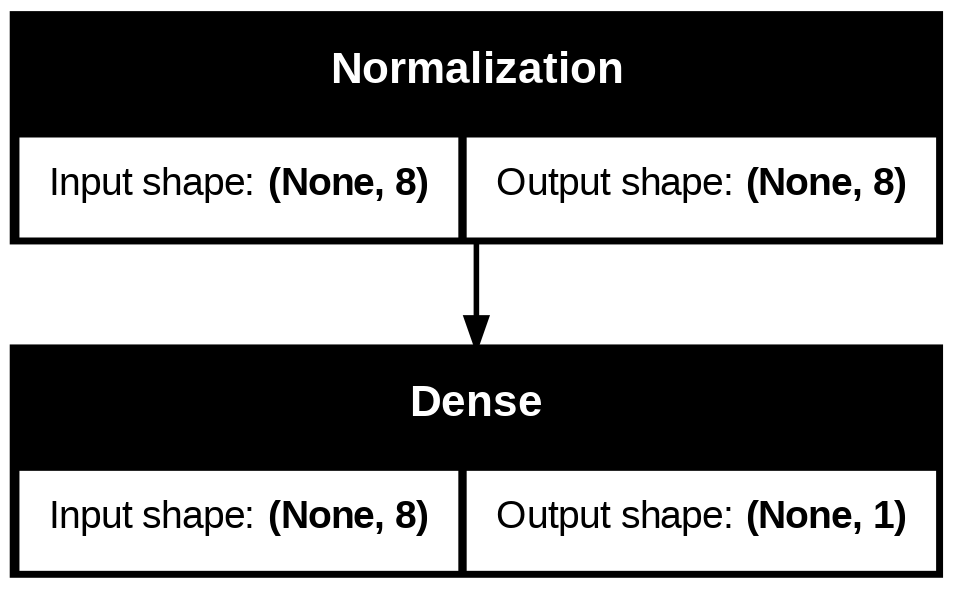

In [52]:
tf.keras.utils.plot_model(model, to_file= "model.png", show_shapes = True)

Error Calculation using MSE,MAE,HUB

if you have an outlier in your dataset and you don't want it ro way too much, then it's not a good idea to use MSE in order not to amplify the error and hence distracting the model

Handeling outliers in the dataset uisng Huber loss is a robust loss function that is less sensitive to outliers than Mean Squared Error (MSE), but behaves like MSE for small errors and like Mean Absolute Error (MAE) for large errors.

in Adam Optimizer the learning rate is used as 0.001 , it could be bigger which could lead to model divergence, and could be smaller and will do better but the training will take too much time to converge

In [59]:
model.compile(optimizer = Adam(learning_rate = 1.0),     # most commonly optimizer used
              loss = MeanAbsoluteError(),     # how the loss will be calc during training
              metrics = [RootMeanSquaredError()]) # RMSE to measure the model performance to compare between model and each other

the training step > model.fit , we can store it in a variable to control it after training or show some stats

In [60]:
history = model.fit(x_train,y_train , validation_data=(x_val , y_val) ,epochs = 100, verbose = 1)

Epoch 1/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 301584.4062 - root_mean_squared_error: 326707.5000 - val_loss: 317932.0938 - val_root_mean_squared_error: 342689.0625
Epoch 2/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 302817.0938 - root_mean_squared_error: 327262.4688 - val_loss: 317908.4062 - val_root_mean_squared_error: 342668.6875
Epoch 3/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 309934.6250 - root_mean_squared_error: 333994.7500 - val_loss: 317884.2500 - val_root_mean_squared_error: 342646.4375
Epoch 4/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 302898.5312 - root_mean_squared_error: 329151.3438 - val_loss: 317860.6250 - val_root_mean_squared_error: 342626.0312
Epoch 5/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 305881.1875 - root_mean_squared_error: 331179.7500 - val_loss: 317836.3750 - val_root_mean_squared_error: 342604.1875
Epoch 6/100
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 306765.0938 - root_mean_squared_error: 331669.4375 - va

getting all the loss values and store in a variable, it will print them if we did not store it in loss_history

In [61]:
history.history

{'loss': [306465.375,
  306439.625,
  306414.25,
  306388.90625,
  306363.40625,
  306338.09375,
  306312.71875,
  306287.21875,
  306261.9375,
  306236.75,
  306211.0625,
  306185.75,
  306160.28125,
  306135.125,
  306109.75,
  306084.40625,
  306058.78125,
  306033.4375,
  306008.125,
  305982.875,
  305957.375,
  305932.0,
  305906.6875,
  305881.09375,
  305855.8125,
  305830.59375,
  305805.125,
  305779.8125,
  305754.3125,
  305728.875,
  305703.6875,
  305678.375,
  305652.75,
  305627.375,
  305602.25,
  305576.625,
  305551.40625,
  305525.875,
  305500.8125,
  305475.1875,
  305449.84375,
  305424.34375,
  305399.03125,
  305373.59375,
  305348.375,
  305322.90625,
  305297.53125,
  305272.09375,
  305246.8125,
  305221.46875,
  305196.0,
  305170.625,
  305145.375,
  305119.8125,
  305094.65625,
  305069.1875,
  305043.84375,
  305018.40625,
  304993.09375,
  304967.46875,
  304942.1875,
  304916.90625,
  304891.8125,
  304865.96875,
  304840.71875,
  304815.5625,
  304789

let's plot the losses over epochs to trace it

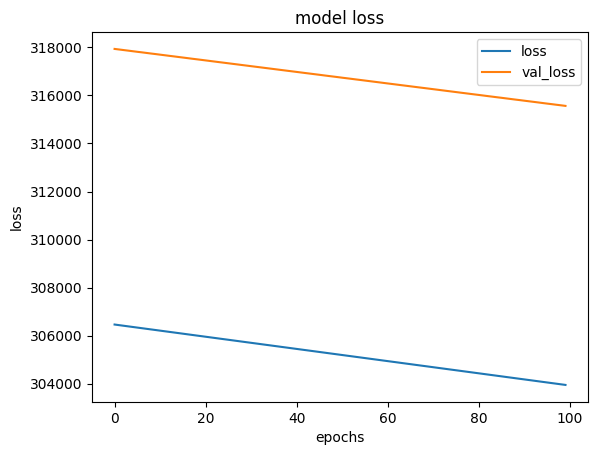

In [62]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend(['loss' , 'val_loss'])
plt.show()

In [41]:
history.history

{'loss': [308513.84375,
  308513.8125,
  308513.75,
  308513.71875,
  308513.6875,
  308513.65625,
  308513.59375,
  308513.59375,
  308513.5,
  308513.5,
  308513.53125,
  308513.4375,
  308513.4375,
  308513.4375,
  308513.375,
  308513.34375,
  308513.34375,
  308513.28125,
  308513.25,
  308513.21875,
  308513.15625,
  308513.15625,
  308513.09375,
  308513.09375,
  308513.03125,
  308513.03125,
  308513.03125,
  308512.9375,
  308512.96875,
  308512.90625,
  308512.9375,
  308512.84375,
  308512.84375,
  308512.78125,
  308512.6875,
  308512.71875,
  308512.625,
  308512.59375,
  308512.59375,
  308512.5625,
  308512.53125,
  308512.46875,
  308512.4375,
  308512.46875,
  308512.40625,
  308512.40625,
  308512.375,
  308512.3125,
  308512.28125,
  308512.28125,
  308512.21875,
  308512.1875,
  308512.125,
  308512.125,
  308512.0625,
  308512.0625,
  308512.03125,
  308512.0,
  308511.9375,
  308511.9375,
  308511.90625,
  308511.84375,
  308511.875,
  308511.78125,
  308511.75,
 

another way to measure the model performance rather than RMSE is model evaluation > model.evaluate(x,y)

model evaluation is used on the validation and test data not the training

evaluate on validation data

In [63]:
model.evaluate(x_val,y_val)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 315456.5000 - root_mean_squared_error: 340039.4062 


[315561.6875, 340578.34375]

eavaluate on testing data

In [64]:
model.evaluate(x_test,y_test)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 315749.3750 - root_mean_squared_error: 341053.9375 


[313008.8125, 338036.53125]

So now let's test it given features of any unseen car to see the price

we use model.predict   for testing

In [65]:
x_test.shape

TensorShape([100, 8])

predicting tha prices for all unseen data

In [66]:
model.predict(x_test)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


array([[2256.3745 ],
       [3349.6387 ],
       [1748.883  ],
       [3149.7769 ],
       [2626.384  ],
       [2245.227  ],
       [1326.1884 ],
       [1161.5713 ],
       [2900.7078 ],
       [1874.1829 ],
       [2289.1833 ],
       [1200.9004 ],
       [1277.9788 ],
       [2941.4734 ],
       [2983.2898 ],
       [2685.27   ],
       [1859.1655 ],
       [3057.0264 ],
       [2372.143  ],
       [ 956.2046 ],
       [2231.1538 ],
       [1560.0521 ],
       [1524.771  ],
       [1853.6581 ],
       [2956.4824 ],
       [2747.1404 ],
       [1950.9939 ],
       [2221.9255 ],
       [2016.1907 ],
       [ 986.3506 ],
       [3074.0427 ],
       [2733.8113 ],
       [3706.803  ],
       [1375.1227 ],
       [2603.4749 ],
       [1453.7705 ],
       [2929.563  ],
       [2020.6257 ],
       [2284.982  ],
       [3085.685  ],
       [2061.7634 ],
       [2019.1638 ],
       [2604.5461 ],
       [2001.0183 ],
       [2054.3113 ],
       [1606.8674 ],
       [2975.5396 ],
       [3792.

In [70]:
model.predict(tf.expand_dims(x_test[0] , axis = 0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step


array([[2256.3745]], dtype=float32)